In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import quad


### Template fitting to convert M1450 -> ionizing Ndot

https://ui.adsabs.harvard.edu/abs/2012MNRAS.427.1800R/abstract

https://ui.adsabs.harvard.edu/abs/2012MNRAS.426.2677R/abstract

https://ui.adsabs.harvard.edu/abs/2015MNRAS.449.4204L/abstract

In [5]:
f_nu=lambda mAB: 10**(-(mAB+48.6)/2.5)
pc2cm=3.086e+18
MagAB_to_Lnu=lambda MagAB: 4*np.pi*(10*pc2cm)**2*f_nu(MagAB) # in unit erg s^-1 Hz^-1
c=2.99792458e10
nuHz_to_lambdaAA=lambda nuHz:1e8*c/nuHz
lambdaAA_to_nuHz=lambda lambdaAA: c/(1e-8*lambdaAA)

nu1450=lambdaAA_to_nuHz(1450)
MagAB_to_nuLnu=lambda MagAB:nu1450*MagAB_to_Lnu(MagAB)
MagAB_to_Liso =lambda MagAB:10**(4.74+0.91*np.log10(MagAB_to_nuLnu(MagAB)))

In [6]:
nu912=lambdaAA_to_nuHz(912)
nu_lo=lambdaAA_to_nuHz(10000) #1 mu m
nu_hi=lambdaAA_to_nuHz(1.5) # 8 keV

def Lum_nu_spec(nu, L_at_nu0, nu0, alpha_nu):
    return L_at_nu0*(nu/nu0)**alpha_nu

def calc_Lbol(L_nu_at912,alpha_nu_red,alpha_nu_blue):
    red=quad(Lum_nu_spec,nu_lo,lambdaAA_to_nuHz(912),args=(L_nu_at912,lambdaAA_to_nuHz(912),alpha_nu_red))[0]
    blue=quad(Lum_nu_spec,lambdaAA_to_nuHz(912),nu_hi,args=(L_nu_at912,lambdaAA_to_nuHz(912),alpha_nu_blue))[0]
    return red+blue

hplanck=6.62607015e-27
def Ndot_nu_spec(nu, L_at_nu0, nu0, alpha_nu):
    return Lum_nu_spec(nu, L_at_nu0, nu0, alpha_nu)/hplanck/nu

def Ndot_tot(Lnu_at_HIedge,alpha_nu):
#     print(lambdaAA_to_nuHz(912),lambdaAA_to_nuHz(12))
#     print(quad(Ndot_nu_spec,lambdaAA_to_nuHz(912),lambdaAA_to_nuHz(0.912),args=(Lnu_at_HIedge,lambdaAA_to_nuHz(912),alpha_nu)))
    return quad(Ndot_nu_spec,lambdaAA_to_nuHz(912),lambdaAA_to_nuHz(0.912),args=(Lnu_at_HIedge,lambdaAA_to_nuHz(912),alpha_nu))[0]


In [7]:
def M1450_to_Ndottot(M1450,method="Runnoe12+Lusso15"):
    if method=="Runnoe12+Lusso15":
        alpha_nu_red=-0.61
        alpha_nu_blue=-1.7
        L_nu_at912=MagAB_to_Liso(M1450)/calc_Lbol(1,alpha_nu_red,alpha_nu_blue)
        return Ndot_tot(L_nu_at912,alpha_nu_blue)

In [10]:
M1450=-26.73
print(M1450_to_Ndottot(M1450), "this is the value in the file name Ntot")
alpha_nu_red=-0.61
alpha_nu_blue=-1.7
L_nu_at912=MagAB_to_Liso(M1450)/calc_Lbol(1,alpha_nu_red,alpha_nu_blue)

1.4003437067434666e+57 this is the value in the file name Ntot


[]

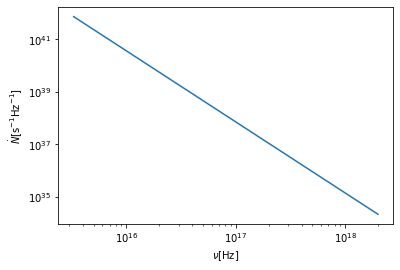

In [11]:
nuArr=np.logspace(np.log10(nu912),np.log10(nu_hi),100)
plt.plot(nuArr,Ndot_nu_spec(nuArr,L_nu_at912,nu912,alpha_nu_blue))
plt.xlabel(r"$\nu \rm [Hz]$")
plt.ylabel(r"$\dot{N} \rm [s^{-1}Hz^{-1}]$")
plt.loglog()

### convert to Gamma

In [77]:
def sigma_HI_nu(nu):
    # atomic data: photo-ionization xsec of HI 
    # input nu in Hz (only works when nu>nuHI)
    # output sigma_HI in cm^2
    
    sigma_HI=6.30e-18*(1.34*(nu/nu912)**-2.99-0.34*(nu/nu912)**-3.99) #cm**2
    return sigma_HI

In [78]:
def calc_4pir2Gamma(M1450,method="Runnoe12+Lusso15"):
    print(M1450_to_Ndottot(M1450)) # this is the value in the file name Ntot
    alpha_nu_red=-0.61
    alpha_nu_blue=-1.7
    L_nu_at912=MagAB_to_Liso(M1450)/calc_Lbol(1,alpha_nu_red,alpha_nu_blue)
    nuArr=np.logspace(np.log10(nu912),np.log10(nu_hi),100)
    intfunc=lambda nu:sigma_HI_nu(nu)*Ndot_nu_spec(nu,L_nu_at912,nu912,alpha_nu_blue)
    ret=quad(intfunc,nu912,nu_hi)[0]
    return ret

In [69]:
calc_4pir2Gamma(-26.73)/4/np.pi/(13*1e6*pc2cm)**2

1.4003437067434666e+57


1.675603872875465e-13

In [64]:
1.7

1.7

In [76]:
calc_4pir2Gamma(-25.1)/4/np.pi/(30*1e6*pc2cm)**2

3.5720262682672787e+56


8.025933382802979e-15